In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
from google.colab import drive
from sklearn.model_selection import train_test_split

# Монтирование Google Drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/RuCoLA/data'

# Загрузка данных
train_data = pd.read_csv(f'{path}/in_domain_train.csv')
test_data = pd.read_csv(f'{path}/in_domain_dev.csv')

# Разделение train_data на train и val
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=True, stratify=train_data['acceptable'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Посмотрим на распределение целевой переменной
train_data['acceptable'].value_counts()

,count
acceptable,
1,5864
0,2005


In [4]:
# Расчет распределения лейблов и весов классов
label_counts = train_data['acceptable'].value_counts()
total_count = len(train_data)
class_weights = {label: total_count / count for label, count in label_counts.items()}
class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float)

### Файнтьюн RuBert

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained('ai-forever/ruBert-base')
model = AutoModelForSequenceClassification.from_pretrained('ai-forever/ruBert-base', num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [6]:
def preprocess_data(data, tokenizer):
    return tokenizer(
        list(data['sentence']),
        add_special_tokens = True,
        truncation = True,
        padding = True,
        return_attention_mask = True,
        return_tensors = "pt"
    )

train_encodings = preprocess_data(train_df, tokenizer)
test_encodings = preprocess_data(test_data, tokenizer)
val_encodings = preprocess_data(val_df, tokenizer)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [7]:
class RuCoLADataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RuCoLADataset(train_encodings, list(train_df['acceptable']))
test_dataset = RuCoLADataset(test_encodings, list(test_data['acceptable']))
val_dataset = RuCoLADataset(val_encodings, list(val_df['acceptable']))

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='binary')
    acc = accuracy_score(labels, pred)
    mcc = matthews_corrcoef(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc
    }

Напишем свой Trainer, чтобы учитывать веса для распределения целевой переменной

In [9]:
from transformers import Trainer, TrainingArguments
from transformers.trainer import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [10]:
# Настройка тренировки
training_args = TrainingArguments(
    output_dir='./results',          # выводимая папка
    num_train_epochs=3,              # количество эпох
    per_device_train_batch_size=16,  # размер батча для тренировки
    per_device_eval_batch_size=64,   # размер батча для валидации
    warmup_steps=500,                # число шагов для обучения
    weight_decay=0.01,               # коэффициент регуляризации
    logging_dir='./logs',            # директория для логов
    logging_steps=10,
    evaluation_strategy='epoch',     # оценка на каждом эпохе
    save_strategy='epoch',           # сохранение модели на каждом эпохе
    load_best_model_at_end=True,     # загрузка лучшей модели по завершении тренировки
    log_level='error'               # уровень логирования (только ошибки)
)

trainer = WeightedTrainer(
    model=model,                         # модель
    args=training_args,                  # аргументы тренировки
    train_dataset=train_dataset,         # тренировочный датасет
    eval_dataset=test_dataset,           # валидационный датасет
    compute_metrics=compute_metrics,     # Функция метрик
    class_weights=class_weights_tensor   # Вес классов
)

# Тренировка модели
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.625600,0.641228,0.775178,0.860744,0.799766,0.931787,0.319578
2,0.500900,0.602475,0.766022,0.843962,0.839406,0.848568,0.376626
3,0.385300,1.113409,0.792472,0.868557,0.822955,0.919509,0.396560


TrainOutput(global_step=1182, training_loss=0.46966463604756015, metrics={'train_runtime': 289.6331, 'train_samples_per_second': 65.203, 'train_steps_per_second': 4.081, 'total_flos': 436715532463500.0, 'train_loss': 0.46966463604756015, 'epoch': 3.0})

Оценки на обучении

In [11]:
results = trainer.evaluate()

print(f"Loss: {results['eval_loss']}")
print(f"F1 Score: {results['eval_f1']}")
print(f"Accuracy: {results['eval_accuracy']}")
print(f"Precision: {results['eval_precision']}")
print(f"Recall: {results['eval_recall']}")
print(f"Mcc: {results['eval_mcc']}")

Loss: 0.6024745106697083
F1 Score: 0.8439620081411127
Accuracy: 0.7660223804679552
Precision: 0.8394062078272605
Recall: 0.8485675306957708
Mcc: 0.3766259221842115


Оценки на валидационном датасете

Метрики на валидационной выборке:
Accuracy: 0.7782719186785261
F1 Score: 0.854157960718763
Precision: 0.8377049180327869
Recall: 0.8712702472293266
Mcc: 0.3939689222690437


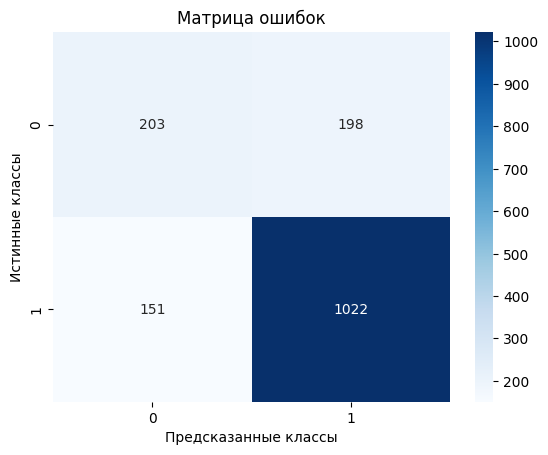

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions, labels, metrics = trainer.predict(val_dataset)

# Преобразование логитов в предсказания классов
predicted_classes = np.argmax(predictions, axis=1)

# Вывод метрик
print("Метрики на валидационной выборке:")
print(f"Accuracy: {metrics['test_accuracy']}")
print(f"F1 Score: {metrics['test_f1']}")
print(f"Precision: {metrics['test_precision']}")
print(f"Recall: {metrics['test_recall']}")
print(f"Mcc: {metrics['test_mcc']}")

conf_matrix = confusion_matrix(labels, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

### RuGPT3

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3medium_based_on_gpt2")
model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3medium_based_on_gpt2")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

Функции для генирации датасета из различного числа few-shot примеров

In [ ]:
_, shots_df = train_test_split(val_df, test_size=0.2, random_state=42, shuffle=True, stratify=val_df['acceptable'])

def get_label(label):
    return 'Да' if label else 'Нет'

def generate_prompt(sentence):
    return f"Это предложение грамматически правильное: {sentence}? Ответ: \n"

def generate_example(sentence, label):
    return f"Пример: {sentence} Ответ: {get_label(label)}\n"

def generate_shot(shots):
    shot = ""
    prompt_idx = len(shots) - 1
    shots.reset_index(inplace=True, drop=True)
    for i in range(prompt_idx):
        shot += generate_example(shots['sentence'][i], shots['acceptable'][i])
    shot += generate_prompt(shots['sentence'][prompt_idx])
    return {'Prompt': shot, 'Label': shots['acceptable'][prompt_idx]}

def make_few_shot_dataset(num_shots):
    df = pd.DataFrame(columns=['Prompt', 'Label'])
    for i in range(0, len(shots_df), num_shots + 1):
        shots = val_df[i : i + num_shots + 1]
        data = generate_shot(shots)
        df = df._append(data, ignore_index=True)
    return df

make_few_shot_dataset(4)

,Prompt,Label
0,Пример: У меня украли кошелек. Ответ: Да\nПрим...,1
1,Пример: Этот в был очень тяжелым. Ответ: Нет\n...,1
2,"Пример: Вероятно, он что-нибудь там делает. От...",1
3,"Пример: Вятский губернатор не принял меня, а в...",1
4,Пример: Сейчас картина была вывезена в Америку...,1
...,...,...
58,"Пример: Потом вскочил, обмотал шею шарфом два ...",1
59,Пример: Маша после моих уговоров помирилась с ...,0
60,Пример: Лицо его очень выразительно: аристокра...,1
61,Пример: Я просто не успел тебя пригласить. Отв...,1


Функция оценки ответов на промпты

In [ ]:
def evaluate_model(predictions, true_labels, title=''):
    labels = [1 if pred == 'Да' else 0 for pred in predictions]
    accuracy = accuracy_score(true_labels, labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, labels, average='binary')
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    conf_matrix = confusion_matrix(true_labels, labels)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.title(f'Матрица ошибок - {title}')
    plt.show()

Функции для предиктов работы с моделью

In [ ]:
from tqdm import tqdm

def get_few_shot_prediction(prompt):
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model.generate(inputs.input_ids.to(device), max_length=500, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return 'Да' if 'Да' in response else 'Нет'

def few_shots_predict(count_shots):
    for shots in count_shots:
        df = make_few_shot_dataset(shots)
        few_shots_predictions = [get_few_shot_prediction(prompt) for prompt in tqdm(df['Prompt'])]
        evaluate_model(few_shots_predictions, list(df['Label']), f'{shots} shots')

Сделаем пару тестов zero/few-shots запросов

zero-shot запросы

In [ ]:
def test_shot_print(sentence, y, y_true):
    print(f'{sentence}, y = {y}, y_true = {y_true}')

zero_shot = "Это предложение грамматически правильное: Его статью приняли в журнал «Филологические науки».? Ответ: "
zero_shot_predict = get_few_shot_prediction(zero_shot)
zero_shot_predict_true = 'Да'
test_shot_print(zero_shot, zero_shot_predict, zero_shot_predict_true)

zero_shot = "Это предложение грамматически правильное: Истребитель накренился, кончик крыла снёс макушку высокого дереву.? Ответьт: "
zero_shot_predict = get_few_shot_prediction(zero_shot)
zero_shot_predict_true = 'Нет'
test_shot_print(zero_shot, zero_shot_predict, zero_shot_predict_true)


Это предложение грамматически правильное: Его статью приняли в журнал «Филологические науки».? Ответ: , y = Нет, y_true = Да
Это предложение грамматически правильное: Истребитель накренился, кончик крыла снёс макушку высокого дереву.? Ответьт: , y = Да, y_true = Нет


На отрицательной метке получаем неверный predict. Попробуем добавить контекст

In [ ]:
few_shot = '''
  Примеры грамматически правильных и не правильных предложений:
  Пример: У Нижнего Новгорода Волга достаточно широка. Ответ: Да
  Пример: Вы одни показался мне веселыми. Ответ: Нет
  Пример: Ивана не было в своей комнате. Ответ: Нет
  Пример: Как я вам сообщаю, Иван приехал. Ответ: Нет
  Это предложение грамматически правильное: Однако космонавты испытывают состояние невесомости, так как они как бы все время падают на Землю, но промахиваются.? Ответ:
'''
few_shot_predict = get_few_shot_prediction(few_shot)
few_shot_predict_true = 'Да'
test_shot_print(few_shot, few_shot_predict, few_shot_predict_true)

few_shot = '''
  Примеры грамматически правильных и не правильных предложений:
  Пример: Она села в самый дальний угол, я ее заметил совершенно случайно. Ответ: Да
  Пример: Университета Бернард Шоу не кончал. Ответ: Да
  Пример: Брат позвонил, когда добравшись до дома. Ответ: Нет
  Это предложение грамматически правильное: Иван выучился в колледже на слесаря и решил пойти на завод им.? Ответ:
'''
few_shot_predict = get_few_shot_prediction(few_shot)
few_shot_predict_true = 'Нет'
test_shot_print(few_shot, few_shot_predict, few_shot_predict_true)



  Примеры грамматически правильных и не правильных предложений:
  Пример: У Нижнего Новгорода Волга достаточно широка. Ответ: Да
  Пример: Вы одни показался мне веселыми. Ответ: Нет
  Пример: Ивана не было в своей комнате. Ответ: Нет
  Пример: Как я вам сообщаю, Иван приехал. Ответ: Нет
  Это предложение грамматически правильное: Однако космонавты испытывают состояние невесомости, так как они как бы все время падают на Землю, но промахиваются.? Ответ:
, y = Да, y_true = Да

  Примеры грамматически правильных и не правильных предложений:
  Пример: Она села в самый дальний угол, я ее заметил совершенно случайно. Ответ: Да
  Пример: Университета Бернард Шоу не кончал. Ответ: Да
  Пример: Брат позвонил, когда добравшись до дома. Ответ: Нет
  Это предложение грамматически правильное: Иван выучился в колледже на слесаря и решил пойти на завод им.? Ответ:
, y = Да, y_true = Нет


Модель опять плохо распознает не правильные предложения.  
Разделим датасет на промпты из раличных zero/few-shot запросов и посомтрим на метрики

100%|██████████| 315/315 [42:50<00:00,  8.16s/it]


Accuracy: 0.30158730158730157
F1 Score: 0.0909090909090909
Precision: 0.7333333333333333
Recall: 0.048458149779735685


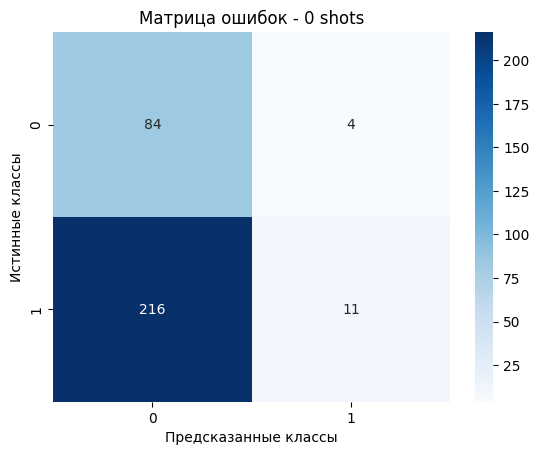

100%|██████████| 158/158 [20:08<00:00,  7.65s/it]


Accuracy: 0.569620253164557
F1 Score: 0.7043478260869566
Precision: 0.675
Recall: 0.7363636363636363


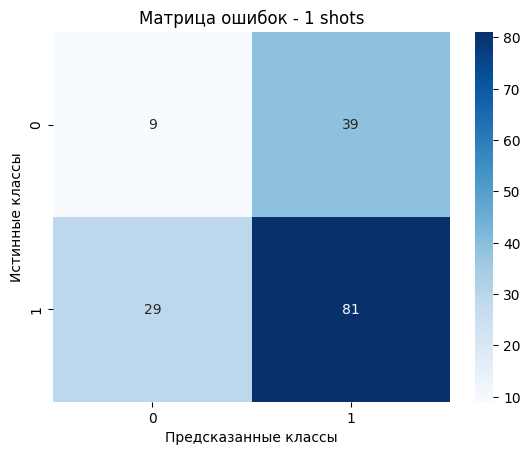

100%|██████████| 105/105 [12:47<00:00,  7.31s/it]


Accuracy: 0.6952380952380952
F1 Score: 0.8181818181818181
Precision: 0.7272727272727273
Recall: 0.935064935064935


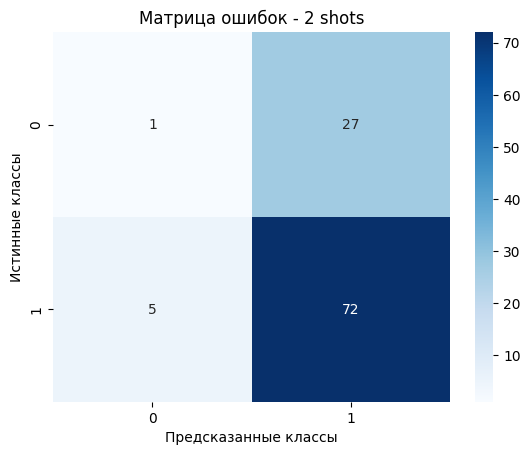

100%|██████████| 63/63 [07:05<00:00,  6.75s/it]


Accuracy: 0.7619047619047619
F1 Score: 0.8648648648648648
Precision: 0.7619047619047619
Recall: 1.0


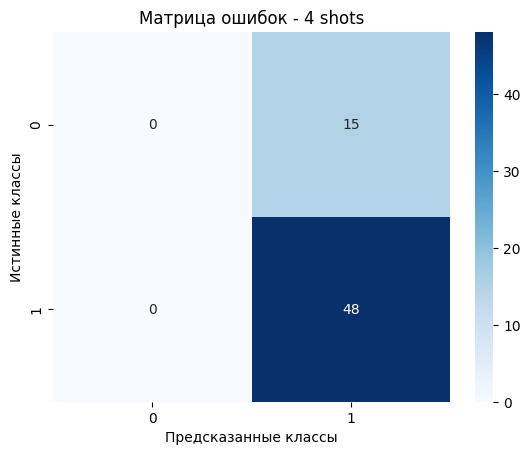

In [ ]:
count_shots = [0, 1, 2, 4]
few_shots_predict(count_shots)

# RuT5

In [3]:
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5Tokenizer,
    T5ForConditionalGeneration,
)
from functools import partial

tokenizer = T5Tokenizer.from_pretrained('sberbank-ai/ruT5-base')
data_collator = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8)
model = T5ForConditionalGeneration.from_pretrained('sberbank-ai/ruT5-base')
model.to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

Расчет метрик для T5

In [4]:
from datasets import load_metric

POS_LABEL = "yes"
NEG_LABEL = "no"

ACCURACY = load_metric("accuracy", keep_in_memory=True)
F1 = load_metric("f1")
PRECISION = load_metric("precision", keep_in_memory=True)
RECALL = load_metric("recall", keep_in_memory=True)
MCC = load_metric("matthews_correlation", keep_in_memory=True)

def compute_metrics(p, tokenizer):
    string_preds = tokenizer.batch_decode(p.predictions, skip_special_tokens=True)
    int_preds = [1 if prediction == POS_LABEL else 0 for prediction in string_preds]

    labels = np.where(p.label_ids != -100, p.label_ids, tokenizer.pad_token_id)
    string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    int_labels = []

    for string_label in string_labels:
        if string_label == POS_LABEL:
            int_labels.append(1)
        elif string_label == NEG_LABEL or string_label == "":  # second case accounts for test data
            int_labels.append(0)
        else:
            raise ValueError()

    acc_result = ACCURACY.compute(predictions=int_preds, references=int_labels)
    f1_result = F1.compute(predictions=int_preds, references=int_labels)
    precision_result = PRECISION.compute(predictions=int_preds, references=int_labels)
    recall_result = RECALL.compute(predictions=int_preds, references=int_labels)
    mcc_result = MCC.compute(predictions=int_preds, references=int_labels)

    return {
        "accuracy": acc_result["accuracy"],
        "f1": f1_result["f1"],
        "precision": precision_result["precision"],
        "recall": recall_result["recall"],
        "mcc": mcc_result["matthews_correlation"]
    }

The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for matthews_correlation contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/matthews_correlation.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Cоздаем датасеты для T5

In [5]:
from datasets import Dataset, DatasetDict
from razdel import tokenize

TRAIN_FILE = path + "/in_domain_train.csv"
IN_DOMAIN_DEV_FILE = path + "/in_domain_dev.csv"
OUT_OF_DOMAIN_DEV_FILE = path + "/out_of_domain_dev.csv"
TEST_FILE = path + "/test.csv"

def read_splits(*, as_datasets):
    train_df, in_domain_dev_df, out_of_domain_dev_df, test_df = map(
        pd.read_csv, (TRAIN_FILE, IN_DOMAIN_DEV_FILE, OUT_OF_DOMAIN_DEV_FILE, TEST_FILE)
    )

    # concatenate datasets to get aggregate metrics
    dev_df = pd.concat((in_domain_dev_df, out_of_domain_dev_df))

    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True, stratify=train_df['acceptable'])

    if as_datasets:
        train, dev, test, val = map(Dataset.from_pandas, (train_df, dev_df, test_df, val_df))
        return DatasetDict(train=train, dev=dev, test=test, val=val)
    else:
        return train_df, dev_df, test_df, val_df

def preprocess_examples(examples, tokenizer):
    result = tokenizer(examples["sentence"], padding=False)

    if "acceptable" in examples:
        label_sequences = []
        for label in examples["acceptable"]:
            if label == 1:
                target_sequence = POS_LABEL
            elif label == 0:
                target_sequence = NEG_LABEL
            else:
                raise ValueError("Unknown class label")
            label_sequences.append(target_sequence)

    else:
        # a hack to avoid the "You have to specify either decoder_input_ids or decoder_inputs_embeds" error
        # for test data
        label_sequences = ["" for _ in examples["sentence"]]

    result["labels"] = tokenizer(label_sequences, padding=False)["input_ids"]
    result["length"] = [len(list(tokenize(sentence))) for sentence in examples["sentence"]]
    return result


splits = read_splits(as_datasets=True)

tokenized_splits = splits.map(
    partial(preprocess_examples, tokenizer=tokenizer),
    batched=True,
    remove_columns=["sentence"],
)

Map:   0%|          | 0/6295 [00:00<?, ? examples/s]

Map:   0%|          | 0/2787 [00:00<?, ? examples/s]

Map:   0%|          | 0/2789 [00:00<?, ? examples/s]

Map:   0%|          | 0/1574 [00:00<?, ? examples/s]

In [6]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    weight_decay=0.01,
    num_train_epochs=20,
    lr_scheduler_type="constant",
    save_strategy="epoch",
    save_total_limit=1,
    seed=RANDOM_SEED,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_mcc",
    group_by_length=True,
    optim="adafactor",
    predict_with_generate=True
)

In [7]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_splits["train"],
    eval_dataset=tokenized_splits["dev"],
    compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,No log,0.246408,0.675637,0.806341,0.675520,1.000000,0.027321
2,No log,0.237887,0.675278,0.806168,0.675278,1.000000,0.000000
3,No log,0.227436,0.678866,0.807403,0.678481,0.996812,0.076681
4,No log,0.252835,0.675637,0.806341,0.675520,1.000000,0.027321
5,No log,0.296788,0.677072,0.807033,0.676492,1.000000,0.061135
6,No log,0.224940,0.693577,0.777256,0.763320,0.791711,0.287467
7,No log,0.218129,0.716900,0.820068,0.718338,0.955367,0.272990
8,No log,0.289355,0.688554,0.812203,0.685036,0.997343,0.159114
9,No log,0.237855,0.727305,0.827430,0.722443,0.968119,0.310718
10,0.439100,0.278039,0.705059,0.820210,0.697026,0.996281,0.244575


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1000, training_loss=0.27362416076660157, metrics={'train_runtime': 1077.5838, 'train_samples_per_second': 116.835, 'train_steps_per_second': 0.928, 'total_flos': 3843970564423680.0, 'train_loss': 0.27362416076660157, 'epoch': 20.0})

In [9]:
results = trainer.evaluate()

print(f"Loss: {results['eval_loss']}")
print(f"F1 Score: {results['eval_f1']}")
print(f"Accuracy: {results['eval_accuracy']}")
print(f"Precision: {results['eval_precision']}")
print(f"Recall: {results['eval_recall']}")
print(f"MCC: {results['eval_mcc']}")

Loss: 0.2510620355606079
F1 Score: 0.8361266294227188
Accuracy: 0.7473986365267312
Precision: 0.743993371996686
Recall: 0.9543039319872476
MCC: 0.3733107559797028


Оценка на валидационном датасете

Метрики на валидационной выборке:
Accuracy: 0.7890724269377383
F1 Score: 0.8702111024237686
Precision: 0.8036101083032491
Recall: 0.948849104859335
MCC: 0.362664210745915


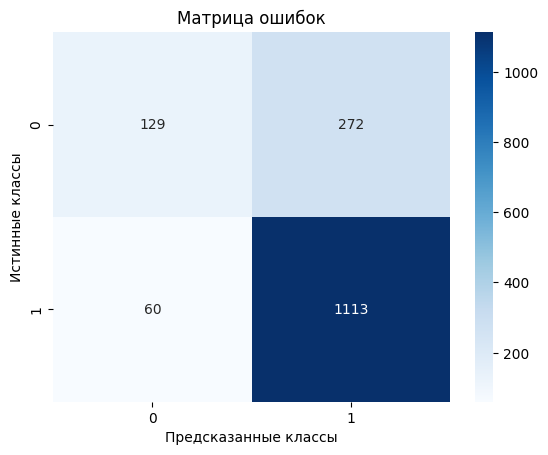

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions, labels, metrics = trainer.predict(tokenized_splits["val"], metric_key_prefix="test", max_length=10)

string_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

binary_predictions = [1 if pred == POS_LABEL else 0 for pred in string_preds]
binary_labels = [1 if lab == POS_LABEL else 0 for lab in string_labels]

# Вывод метрик
print("Метрики на валидационной выборке:")
print(f"Accuracy: {metrics['test_accuracy']}")
print(f"F1 Score: {metrics['test_f1']}")
print(f"Precision: {metrics['test_precision']}")
print(f"Recall: {metrics['test_recall']}")
print(f"MCC: {metrics['test_mcc']}")

conf_matrix = confusion_matrix(binary_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

Вывод:  
Работа с помощью zero/few-shots оказалась самой неэффективной.  
Bert и T5 показали результаты лучше на валидационной выборке.
Для Берта были применены весовые коэф для меток класса, из-за чего увеличился его precision относительно T5.  
У T5 же получился более лучше recall, но к T5 более трудно применить взвешивающие коэффициенты для меток классов, он только изредка верно определяет предложения с ошибками.